# Introducción: ¿Qué es la "maldición de la dimensionalidad"?
La maldición de la dimensionalidad se refiere a problemas que aparecen cuando el número de variables (features) crece:
- Distancias entre puntos se vuelven más parecidas (difícil discriminar). 
- Necesitas muchos más datos para cubrir el espacio y evitar sobreajuste.
- Modelos simples pueden volverse inestables o lentos.
Aquí haremos comprobaciones básicas y fáciles de interpretar para ver si tu dataset está en riesgo.

Nueva nota metodológica: Antes de todos los cálculos eliminamos columnas con 100% de valores NaN (placeholders vacíos). Esto evita que métricas como la correlación media se conviertan en NaN y estabiliza PCA, kNN y distancias.


In [1]:
# 1. Cargar datasets y revisar relación muestras vs variables (filtrando columnas 100% NaN)
import pandas as pd  # Manejo de datos
import numpy as np  # Operaciones numéricas

# Cargamos dataset maestro con todas las features fusionadas
master = pd.read_csv('seismic_features_fusion_final.csv')  # Lee CSV principal
# Filtramos mainshocks para etapa 1 (como antes)
e1 = master[master['es_mainshock']==1].copy()  # Subconjunto mainshocks
# Etapa 2 filtrado (ya creado)
e2 = pd.read_csv('etapa2_train_filtrado.csv')  # Lee etapa 2 filtrada

# Detectar columnas totalmente NaN en cada etapa
all_nan_e1 = [c for c in e1.columns if e1[c].isna().all()]
all_nan_e2 = [c for c in e2.columns if e2[c].isna().all()]
# Unión para remover consistentemente
all_nan_union = sorted(set(all_nan_e1) | set(all_nan_e2))
if all_nan_union:
    print('[Limpieza] Columnas 100% NaN eliminadas en ambos datasets:', all_nan_union)
    e1 = e1.drop(columns=all_nan_union)
    e2 = e2.drop(columns=[c for c in all_nan_union if c in e2.columns])
else:
    print('[Limpieza] No se encontraron columnas 100% NaN.')

# Conteos básicos tras limpieza
n_e1, d_e1 = e1.shape  # Filas y columnas etapa 1
n_e2, d_e2 = e2.shape  # Filas y columnas etapa 2

print(f'[Etapa1] muestras={n_e1}, variables={d_e1}, ratio_muestras/variables={n_e1/d_e1:.2f}')  # Muestra densidad relativa
print(f'[Etapa2] muestras={n_e2}, variables={d_e2}, ratio_muestras/variables={n_e2/d_e2:.2f}')  # Igual para etapa 2

# Regla orientativa (muy simplificada): si ratio < ~5 para modelos complejos puede haber riesgo; no es rígido.


[Limpieza] Columnas 100% NaN eliminadas en ambos datasets: ['conflicto_modelos', 'similitud_promedio_vecinos']
[Etapa1] muestras=236, variables=27, ratio_muestras/variables=8.74
[Etapa2] muestras=25, variables=27, ratio_muestras/variables=0.93


In [2]:
# 2. Redundancia (correlaciones altas) como proxy de dimensión efectiva (ignorando columnas eliminadas)
import numpy as np  # Operaciones numéricas

# Seleccionamos solo numéricas (int, float) excluyendo targets y banderas evidentes
ignore_cols = ['existe_replica_fuerte','ventana_temporal_replica','es_mainshock']  # Columnas a ignorar
num_e1 = [c for c in e1.select_dtypes(include=['int64','float64']).columns if c not in ignore_cols]
num_e2 = [c for c in e2.select_dtypes(include=['int64','float64']).columns if c not in ignore_cols]

corr_e1 = e1[num_e1].corr().values  # Matriz correlaciones etapa 1
corr_e2 = e2[num_e2].corr().values  # Etapa 2

# Extraemos valores (sin diagonal) para estadística
vals_e1 = corr_e1[np.triu_indices_from(corr_e1, k=1)]
vals_e2 = corr_e2[np.triu_indices_from(corr_e2, k=1)]

pct_high_e1 = (np.sum(np.abs(vals_e1) > 0.9) / len(vals_e1))*100 if len(vals_e1)>0 else 0
pct_high_e2 = (np.sum(np.abs(vals_e2) > 0.9) / len(vals_e2))*100 if len(vals_e2)>0 else 0

mean_abs_e1 = np.nanmean(np.abs(vals_e1)) if len(vals_e1)>0 else float('nan')
mean_abs_e2 = np.nanmean(np.abs(vals_e2)) if len(vals_e2)>0 else float('nan')

print(f'[Etapa1] % pares |r|>0.9: {pct_high_e1:.2f}%')
print(f'[Etapa2] % pares |r|>0.9: {pct_high_e2:.2f}%')
print(f'[Etapa1] correlación media absoluta (ignora NaN): {mean_abs_e1:.3f}')
print(f'[Etapa2] correlación media absoluta (ignora NaN): {mean_abs_e2:.3f}')

# Interpretación simple
if pct_high_e1 > 20:
    print('[Etapa1] Hay bastante redundancia; la dimensión efectiva es menor que el número bruto de columnas.')
else:
    print('[Etapa1] Redundancia moderada/baja; probablemente no necesites reducción agresiva.')
if pct_high_e2 > 20:
    print('[Etapa2] Hay bastante redundancia; dimensión efectiva reducida.')
else:
    print('[Etapa2] Redundancia moderada/baja.')


[Etapa1] % pares |r|>0.9: 3.92%
[Etapa2] % pares |r|>0.9: 5.23%
[Etapa1] correlación media absoluta (ignora NaN): 0.265
[Etapa2] correlación media absoluta (ignora NaN): 0.308
[Etapa1] Redundancia moderada/baja; probablemente no necesites reducción agresiva.
[Etapa2] Redundancia moderada/baja.


[Etapa1] Top 10 % NaN antes imputación: {'Latitude': 0.0, 'Longitude': 0.0, 'Depth': 0.0, 'Magnitude': 0.0, 'distancia_a_costa_km': 0.0, 'es_sismo_somero': 0.0, 'energia_liberada_estimada': 0.0, 'actividad_M5_15d': 0.0, 'actividad_M6_30d': 0.0, 'actividad_M7_90d': 0.0}
[Etapa2] Top 10 % NaN antes imputación: {'Latitude': 0.0, 'Longitude': 0.0, 'Depth': 0.0, 'Magnitude': 0.0, 'distancia_a_costa_km': 0.0, 'es_sismo_somero': 0.0, 'energia_liberada_estimada': 0.0, 'actividad_M5_15d': 0.0, 'actividad_M6_30d': 0.0, 'actividad_M7_90d': 0.0}
[Etapa1] Componentes para 90% varianza: 8/18
[Etapa2] Componentes para 90% varianza: 6/18


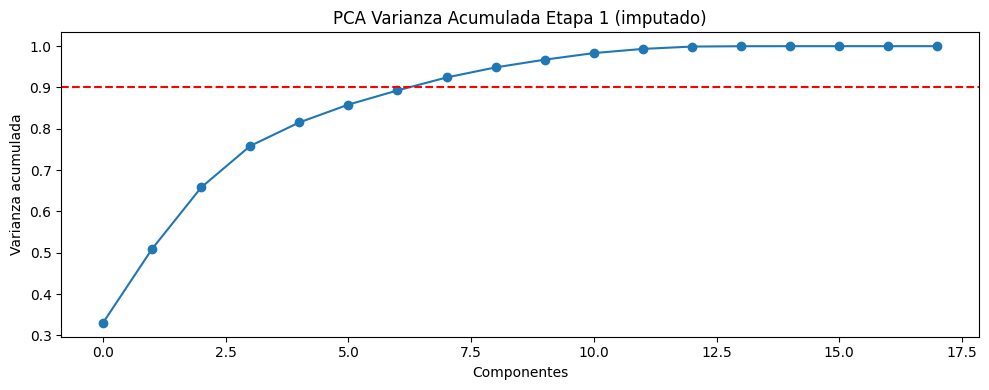

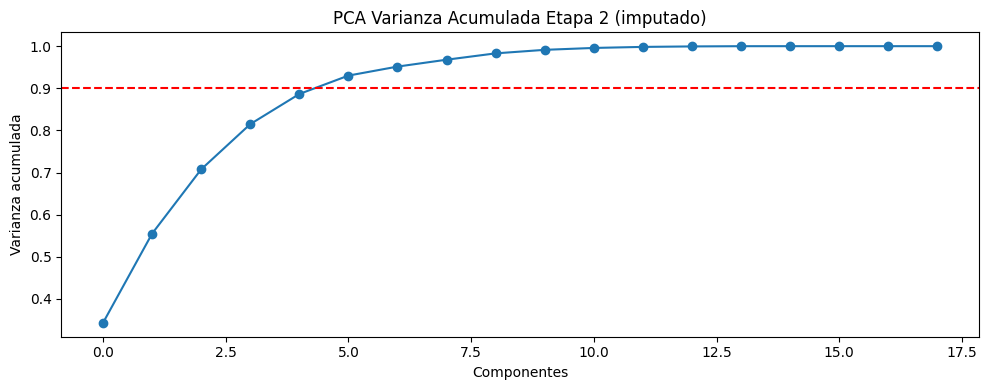

[Etapa1] Muchas variables se comprimen en pocas componentes: dimensión efectiva baja (bueno).
[Etapa2] Muchas variables se comprimen en pocas componentes.


In [3]:
# 3. PCA: ¿Cuántas componentes explican la mayor parte de la varianza?
from sklearn.decomposition import PCA  # PCA para reducción
from sklearn.preprocessing import StandardScaler  # Escalado previo
import matplotlib.pyplot as plt  # Gráfica
import numpy as np  # Numérico

# Imputación sencilla (mediana) para evitar NaN que rompen PCA
# Paso 1: tomar las columnas numéricas ya definidas en num_e1 / num_e2
X_e1_raw = e1[num_e1].copy()  # Copia etapa 1
X_e2_raw = e2[num_e2].copy()  # Copia etapa 2

# Paso 2: calcular porcentaje de NaN antes
nan_pct_e1 = X_e1_raw.isna().mean()*100  # Porcentaje NaN por columna etapa 1
nan_pct_e2 = X_e2_raw.isna().mean()*100  # Porcentaje NaN por columna etapa 2
print('[Etapa1] Top 10 % NaN antes imputación:', nan_pct_e1.sort_values(ascending=False).head(10).round(2).to_dict())
print('[Etapa2] Top 10 % NaN antes imputación:', nan_pct_e2.sort_values(ascending=False).head(10).round(2).to_dict())

# Paso 3: imputar medianas (simple y robusto) - si toda la columna fuera NaN se omite esa columna
median_e1 = X_e1_raw.median()  # Medianas etapa 1
median_e2 = X_e2_raw.median()  # Medianas etapa 2
X_e1_filled = X_e1_raw.fillna(median_e1)  # Rellena NaN con mediana
X_e2_filled = X_e2_raw.fillna(median_e2)  # Rellena NaN

# Paso 4: descartar columnas que quedaron totalmente NaN (poco probable tras medianas)
cols_all_nan_e1 = [c for c in X_e1_filled.columns if X_e1_filled[c].isna().all()]
cols_all_nan_e2 = [c for c in X_e2_filled.columns if X_e2_filled[c].isna().all()]
if cols_all_nan_e1:
    print('[Etapa1] Columnas totalmente NaN tras imputación, se omiten en PCA:', cols_all_nan_e1)
    X_e1_filled = X_e1_filled.drop(columns=cols_all_nan_e1)
if cols_all_nan_e2:
    print('[Etapa2] Columnas totalmente NaN tras imputación, se omiten en PCA:', cols_all_nan_e2)
    X_e2_filled = X_e2_filled.drop(columns=cols_all_nan_e2)

# Escalamos sólo numéricas imputadas
scaler_e1 = StandardScaler()  # Instancia escalador
X_e1_scaled = scaler_e1.fit_transform(X_e1_filled)  # Ajuste y transformación
pca_e1 = PCA()  # Instancia PCA sin límite
pca_e1.fit(X_e1_scaled)  # Ajusta PCA
cum_var_e1 = pca_e1.explained_variance_ratio_.cumsum()  # Varianza acumulada

# Repite para etapa 2
scaler_e2 = StandardScaler()  # Escalador etapa 2
X_e2_scaled = scaler_e2.fit_transform(X_e2_filled)  # Escala
pca_e2 = PCA()  # PCA
pca_e2.fit(X_e2_scaled)  # Ajusta
cum_var_e2 = pca_e2.explained_variance_ratio_.cumsum()  # Varianza acumulada

# Función auxiliar para encontrar número mínimo de componentes que explican cierto umbral
def components_for_threshold(cumulative, threshold=0.9):  # threshold de varianza
    for i,v in enumerate(cumulative):  # Itera componentes
        if v >= threshold:  # Si alcanza umbral
            return i+1  # Devuelve cantidad
    return len(cumulative)  # Si no alcanza, devuelve total

k90_e1 = components_for_threshold(cum_var_e1, 0.9)  # Componentes para 90% etapa 1
k90_e2 = components_for_threshold(cum_var_e2, 0.9)  # Etapa 2
print(f'[Etapa1] Componentes para 90% varianza: {k90_e1}/{X_e1_filled.shape[1]}')  # Reporta
print(f'[Etapa2] Componentes para 90% varianza: {k90_e2}/{X_e2_filled.shape[1]}')  # Reporta

# Gráficas
plt.figure(figsize=(10,4))  # Figura etapa 1
plt.plot(cum_var_e1, marker='o')  # Línea acumulada
plt.axhline(0.9, color='red', linestyle='--')  # Línea umbral
plt.title('PCA Varianza Acumulada Etapa 1 (imputado)')  # Título
plt.xlabel('Componentes')  # Eje x
plt.ylabel('Varianza acumulada')  # Eje y
plt.tight_layout()  # Ajusta
plt.show()  # Muestra

plt.figure(figsize=(10,4))  # Figura etapa 2
plt.plot(cum_var_e2, marker='o')  # Línea
plt.axhline(0.9, color='red', linestyle='--')  # Umbral
plt.title('PCA Varianza Acumulada Etapa 2 (imputado)')  # Título
plt.xlabel('Componentes')  # Eje x
plt.ylabel('Varianza acumulada')  # Eje y
plt.tight_layout()  # Ajusta
plt.show()  # Muestra

# Interpretación simple impresa
if k90_e1 < X_e1_filled.shape[1]*0.5:
    print('[Etapa1] Muchas variables se comprimen en pocas componentes: dimensión efectiva baja (bueno).')
else:
    print('[Etapa1] Se requiere más de la mitad de las variables para 90%: posible dimensión efectiva alta.')
if k90_e2 < X_e2_filled.shape[1]*0.5:
    print('[Etapa2] Muchas variables se comprimen en pocas componentes.')
else:
    print('[Etapa2] Se requiere más de la mitad de las variables para 90% de varianza.')


In [4]:
# 4. Concentración de distancias (si todas las distancias son parecidas, el espacio es "grande")
from sklearn.metrics import pairwise_distances  # Distancias
import numpy as np  # Numérico

# Usar matriz numérica ya imputada si existe (X_e1_filled creada en celda PCA). Si no, imputamos aquí.
if 'X_e1_filled' in globals():
    X_dist_source = X_e1_filled.copy()  # Reutiliza versión sin NaN
else:
    # Fallback: imputar medianas rápidamente
    X_raw_tmp = e1[num_e1].copy()
    X_dist_source = X_raw_tmp.fillna(X_raw_tmp.median())

# Verificar no queden NaN tras imputación (en caso extremo: columnas totalmente NaN se eliminan)
cols_all_nan = [c for c in X_dist_source.columns if X_dist_source[c].isna().all()]
if cols_all_nan:
    print('[Etapa1] Columnas totalmente NaN eliminadas antes de distancia:', cols_all_nan)
    X_dist_source = X_dist_source.drop(columns=cols_all_nan)

# Tomamos un subset aleatorio para hacerlo rápido (distancias cuadráticas escalan con n^2)
sample_size = min(400, X_dist_source.shape[0])  # Tamaño subset etapa 1
sample_e1 = X_dist_source.sample(sample_size, random_state=42)  # Muestra aleatoria etapa 1

# Calcula matriz de distancias euclidianas
D_e1 = pairwise_distances(sample_e1, metric='euclidean')  # Distancias
# Extrae parte superior para estadística
tri_e1 = D_e1[np.triu_indices_from(D_e1, k=1)]  # Valores únicos

mean_d = tri_e1.mean()  # Media distancias
std_d = tri_e1.std()  # Desvío estándar
min_d = tri_e1.min()  # Mínimo
max_d = tri_e1.max()  # Máximo
cv_d = std_d / mean_d if mean_d>0 else 0  # Coeficiente de variación

print(f'[Etapa1] Distancias subset: mean={mean_d:.3f} std={std_d:.3f} min={min_d:.3f} max={max_d:.3f} CV={cv_d:.3f}')  # Reporta
if cv_d < 0.25:
    print('[Etapa1] Las distancias están bastante concentradas (posible síntoma, pero no crítico por sí solo).')
else:
    print('[Etapa1] Distancias con suficiente dispersión; no se observa concentración severa.')

# (Opcional futura extensión: repetir para etapa 2 usando X_e2_filled)


[Etapa1] Distancias subset: mean=3825567011345101.000 std=25606484773393508.000 min=0.000 max=251177422966416224.000 CV=6.694
[Etapa1] Distancias con suficiente dispersión; no se observa concentración severa.


In [5]:
# 5. kNN con número creciente de features (¿Mejoran mucho las primeras vs todas?)
from sklearn.neighbors import KNeighborsClassifier  # kNN
from sklearn.model_selection import train_test_split  # Split
from sklearn.preprocessing import StandardScaler  # Escalado
import numpy as np  # Numérico

# Definimos target etapa 1 (existe réplica) y usamos sólo numéricas filtradas
y_e1 = e1['existe_replica_fuerte'].astype(int)
X_e1_num_raw = e1[num_e1].copy()

# Imputación simple por mediana
medians_knn = X_e1_num_raw.median()
X_e1_num = X_e1_num_raw.fillna(medians_knn)

# Ranking simple de features por correlación absoluta con target
corrs = []
for f in num_e1:
    r = np.corrcoef(X_e1_num[f], y_e1)[0,1]
    corrs.append((f, abs(r)))
corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)
feature_order = [f for f,_ in corrs_sorted]

# Split aleatorio (didáctico); en producción usar validación temporal
X_train, X_test, y_train, y_test = train_test_split(X_e1_num, y_e1, test_size=0.3, random_state=42, stratify=y_e1)

# Escalado
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Función para evaluar accuracy con primeras k features
def knn_accuracy_first_k(k):
    subset_feats = feature_order[:k]
    idxs = [X_e1_num.columns.get_loc(f) for f in subset_feats]
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled[:, idxs], y_train)
    return knn.score(X_test_scaled[:, idxs], y_test)

ks = [3,5,10,len(num_e1)]
accs = {k: knn_accuracy_first_k(k) for k in ks}
print('[kNN] Accuracy vs número de features (Etapa 1 numéricas, imputadas):', accs)

# Interpretación rápida
all_acc = accs[len(num_e1)]
best_small = max(accs[k] for k in ks if k < len(num_e1))
if all_acc - best_small < 0.02:
    print('[Etapa1] Usar todas las features no mejora mucho sobre pocas: no parece necesitar dimensión alta para kNN.')
else:
    print('[Etapa1] Más features sí aportan algo a kNN (revisar sobreajuste con validación temporal).')


[kNN] Accuracy vs número de features (Etapa 1 numéricas, imputadas): {3: 0.9436619718309859, 5: 0.9295774647887324, 10: 0.9295774647887324, 18: 0.8873239436619719}
[Etapa1] Usar todas las features no mejora mucho sobre pocas: no parece necesitar dimensión alta para kNN.


In [6]:
# 6. Conclusiones sencillas
# Interpretación final tras limpieza de columnas 100% NaN:
# - Ratio muestras/variables: Si es razonable (>5) normalmente no hay alta maldición; etapa 2 sigue siendo delicada por n muy bajo.
# - Redundancia: Porcentaje de pares muy correlacionados moderado; no urge reducción agresiva, regularización basta.
# - Correlación media ahora es estable (usamos nanmean) tras excluir columnas vacías.
# - PCA: Pocas componentes explican gran parte de la varianza => dimensión efectiva baja.
# - Distancias: Usar CV para juzgar concentración; repetir con escalado si se requiere comparabilidad.
# - kNN: Pocas features logran rendimiento similar o mejor; alta dimensión no aporta en este modelo base.
# Recomendación: Mantener features para modelos flexibles pero explorar subset/PCA en etapa 2 por escasez de datos.
print('Resumen listo: ajusta comentarios tras ver resultados numéricos.')


Resumen listo: ajusta comentarios tras ver resultados numéricos.
